In [1]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm
import time
from scipy.optimize import minimize

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import quantstats as qs
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline


from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from pandas.tseries.offsets import BDay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

In [2]:
Path_stocks = Path(r'C:\Users\Strahinja\Desktop\books_Germany\Quant\Group_Project\qs\data\permno_selection.csv')
df_input_stocks = pd.read_csv(Path_stocks)
Path_linker = Path(r'C:\Users\Strahinja\Desktop\books_Germany\Quant\Group_Project\qs\data\daily_permno_secid_cusip_link.csv.zip')
zip_file = ZipFile(Path_linker)
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))
Path1 = Path(r'C:\Users\Strahinja\Desktop\books_Germany\Quant\Homework_1\data_snp500.h5')

In [3]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            """

    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # dropna
    df_stock_data.dropna(inplace=True)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

In [4]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

In [5]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

In [6]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_ffm = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_ffm = calc_excess_return(df=df_stocks_ffm, minuend=minuend, subtrahend=subtrahend)
    
    return df_stocks_ffm

In [7]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2020-12-31',
                        df_link=df_link_permno_secid,
                        wrds_username='strahinja23',
                        minuend='ret',
                        subtrahend='rf')

Loading library list...
Done


In [8]:
def estimate_betas(df, window_size, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[['mktrf', 'smb', 'hml', 'mom']]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    # print df_ols
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # create a temporary copy of df_ols
        df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_ols
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        for var in ["const_eom", "beta1_eom", "beta2_eom", "beta3_eom", "beta4_eom"]:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)

        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [9]:
df_betas = estimate_betas(df=df_prepared, window_size=252, period='monthly')

100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Merging the dataframes...


In [10]:
df_features = pd.read_hdf(Path1,key='Homework2')
df_features = df_features[['date','permno','iv','skew1','skew2','vrp']]
df_betas = df_betas.merge(df_features,how='left',on=['date','permno'])
df_betas.loc[:,'date'] = pd.to_datetime(df_betas.loc[:,'date'])

## Code for Normalization and Rolling Window regression

In [11]:
def train_test_split_sorted(df,date_of_split, dates):   
    
    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[(df["date"] <= date_of_split) & (df['date'] > pd.datetime(1999, 12, 31))]
    X_test = df[(df["date"] > date_of_split) & (df['date'] < pd.datetime(2020, 1, 1))]
    
    X_train = X_train.sort_values(by=['date','permno'])
    X_test = X_test.sort_values(by=['date','permno'])

    return X_train,X_test

In [12]:
train,test = train_test_split_sorted(df_betas,pd.datetime(2012, 12, 31),df_betas.date)

In [13]:
def technicals_rock(df_a):
    
    KAMA = KAMAIndicator(close = df_a["prc"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["prc"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["prc"],window=12)
    RSI = RSIIndicator(close=df_a["prc"],window = 14)
    EMA14 = EMAIndicator(close = df_a["prc"],window = 14)
    EMA25 = EMAIndicator(close = df_a["prc"],window = 25)
    MACD_ind = MACD(close = df_a["prc"],window_slow = 26,window_fast = 12,window_sign=9)
    Aroon = AroonIndicator(close = df_a["prc"],window = 25)
    
    df_a = df_a.assign(    
    KAMA = KAMA.kama(),
    PPO = PPO.ppo_signal(),
    ROCI = ROCI.roc(),
    RSI = RSI.rsi(),
    EMA14 = EMA14.ema_indicator(),
    EMA25 = EMA25.ema_indicator(),
    MACD = MACD_ind.macd_signal(),
    AroonInd = Aroon.aroon_indicator()
    )
    
    return df_a

In [14]:
def process(df,columns):
    df_scaled = df.copy()

    df_scaled = df_scaled.fillna(method='ffill',limit=30,inplace=False)
    df_scaled = df_scaled.dropna()
    
    for column in columns:
        df_scaled[column] = (df_scaled[column] - df_scaled[column].mean())  / df_scaled[column].std()
        df_scaled.loc[:,column] = winsorize(df_scaled.loc[:,column], limits=0.03).data
                                                                     
    df_scaled.loc[:,'fret1d'] = df_scaled.groupby(['permno'])['ret'].shift(-1)
    
    df_scaled = df_scaled.dropna()
    
    return df_scaled

In [15]:
columns2norm = ['skew1', 'skew2', 'iv','vrp','KAMA','PPO','RSI']

train = process(technicals_rock(train),columns2norm)
test = process(technicals_rock(test),columns2norm)

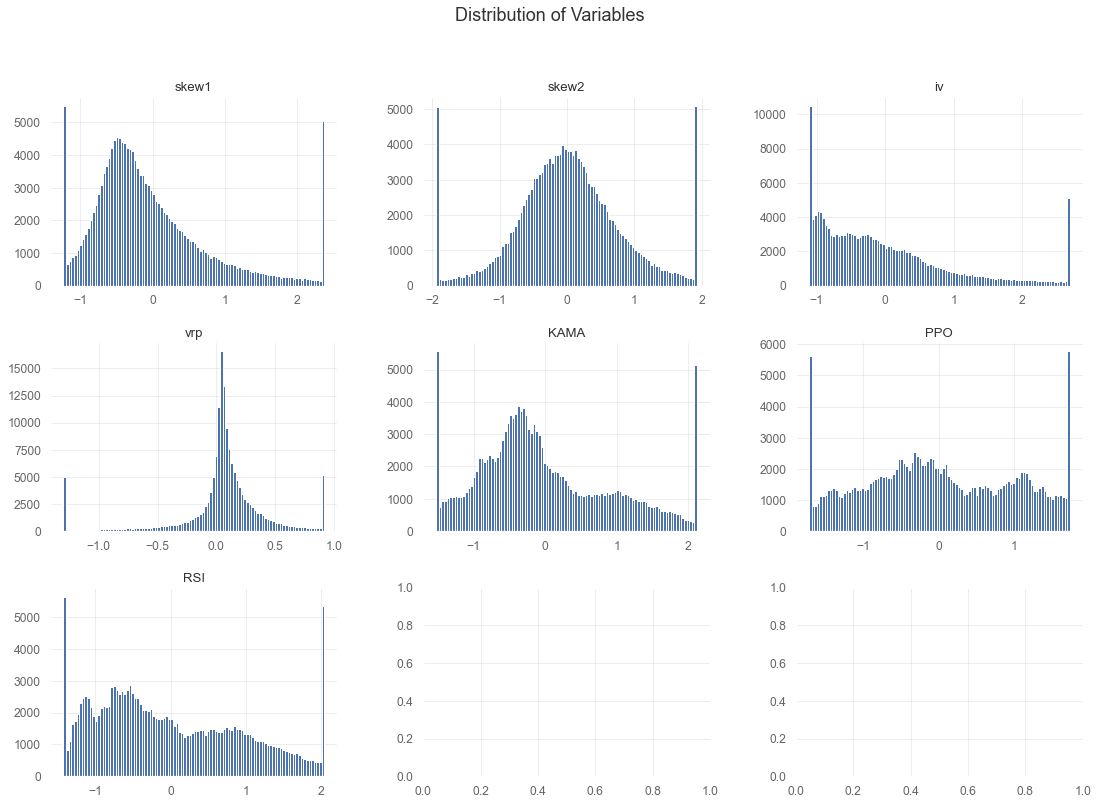

In [16]:
cols = ['skew1', 'skew2', 'iv','vrp','KAMA','PPO','RSI' ]#,'AroonInd']
fig, axs = plt.subplots(3,3)
fig.set_size_inches(18.5, 12.5, forward=True)
fig.suptitle('Distribution of Variables', fontsize=18)

for i,el in enumerate(cols):
    a = train.hist(el, ax=axs.flatten()[i],bins=100)


In [17]:
def Rolling_Forest(data,predictors,target,window,params):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data['constant'] = 1.0
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
  #  scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
        try:
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            linreg = RandomForestRegressor(**params)
            fit_ = linreg.fit(train_window[predictors],train_window[target])
            predi_df = data[data['date']== pred_date].loc[:,predictors+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
          #  score_r2 = linreg.score(train[predictors], train[target])
          #  scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
   # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:] , missing_dates #, r2_average

In [18]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [19]:
params = {
        'n_estimators': [10, 20, 30],
        'max_features': ['sqrt','auto','log2'],
        'max_depth': [3, 4, 5],
        'min_samples_leaf':[1,2,3,4],
        'min_samples_split':[2,3,4,5]
        }

regressors = ['skew1', 'skew2', 'iv','vrp']
target = ['fret1d']


forest = RandomForestRegressor()

folds = 3
param_comb = 5

random_search = RandomizedSearchCV(forest, param_distributions=params, n_iter=param_comb, scoring='r2', 
                                   n_jobs=4, cv=KFold(5), verbose=3, random_state=1001 )
                                                #KFold is not shuffled !

# Here we go 
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train[regressors], train[target])
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   23.5s finished



 Time taken: 0 hours 0 minutes and 28.93 seconds.


In [20]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
RandomForestRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=30)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
-1.0007060496298856

 Best hyperparameters:
{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3}


In [21]:
params_forest = {
    "n_estimators": 30,
    'max_features':'auto', 
    'max_depth':3,
    'min_samples_leaf':4,
    'min_samples_split':4,
    'random_state':1001,
    }

real_returns, expected_returns,missing_dates = Rolling_Forest(train,regressors,target,21,params_forest)

## Backtest

In [22]:
def prepare_returns(real, expected, days_to_test):


    real = real.loc[np.logical_and(real.index >= days_to_test - pd.Timedelta(days=252*5 + 1), real.index < days_to_test), :]
    expected = expected.loc[np.logical_and(expected.index >= days_to_test - pd.Timedelta(days=252*5 + 1), expected.index < days_to_test), :]   
    
    real = real.fillna(0.0)
    expected = expected.fillna(0.0)
    
    return real, expected

In [23]:
ret, expret = prepare_returns(real_returns,expected_returns,pd.datetime(2012, 12, 28))

In [24]:
def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]  # Max Sharp Ratio
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr / 10000

In [25]:
def Benchmark_Drawdown_Rolling(df,ret,d,lookback):
    
    d = pd.Timestamp(d)
    start = d - BDay(lookback)
    
    means = ret.loc[start:d,:].mean().values
    cov_var = ret.loc[start:d,:].cov().values
    
    weights_bench = df[(df['date']>= start) & (df['date'] < d)]
    weights_bench = weights_bench[['permno','weightage_pct']]
    weights_bench = weights_bench.sort_values(by='permno').set_index(['permno'])
    weights_bench = np.array(weights_bench)
    
    
    
    drawdown_on_window_normal = np.array(norm.pdf(
        0.01,
        loc = means.dot(weights_bench),
        scale = np.sqrt(np.array(w.T)@cov_var@np.array(w))    
    ))
    
    return means,cov_var , drawdown_on_window_normal
    

In [26]:
def configure_inputs_for_optimisation(df, ret, expret, d, limit,lookback):

    cov = ret.cov().values
    mu  = expret.iloc[-1].values
    
    if np.sum(mu > 0) == 0:
        mu -= mu.mean()
    
 # ----- Bounds on Weights Based on Benchmark on day d  ---- #
    bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
    for en,i in enumerate(ret.columns, start=0): # 
        
        lower_bound = 0.9*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        higher_bound = 1.1*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        bounds[en].extend((lower_bound,higher_bound))
              
 # ----- Constraints on Factor Exposure: ---- #
    cons = []
    fact = pd.DataFrame(columns=regressors+['permno'] )
    fact.permno = ret.columns.tolist()
    fact.set_index('permno', inplace=True)
    fact = fact.fillna(0.0)
    
    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df['date'] == d, df['permno'] == stock)
            if flt.any():
                fact.loc[stock, fct] = train.loc[flt, fct].values[0]
    
    B = fact.T
    
    cons.append({'type': 'ineq', 'fun' : lambda wvec: limit - B@wvec})
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@wvec + limit}) 
 
 # ----- Constraints on Weight Sum (long portfolio): ---- #

    cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})

#  # ----- Constraints on Drawdown: ---- #
#     if (pd.Timestamp(d)- BDay(lookback)) in ret.index :
#                                  means, cov_var, bench_dd = Benchmark_Drawdown_Rolling(df,ret,d,lookback=21)
#                                  qs_dd = np.array(norm.pdf(0.01,loc = means@wvec, scale = np.sqrt(np.array(wvec.T)@cov_var@np.array(wvec))))
#                                  cons.append({'type': 'ineq', 'fun' : lambda wvec: (qs_dd - bench_dd +0.01)})                                                                  
                                        
                                 
    return cov, mu, cons, bounds

In [27]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

## Sanity Check on Weight Bounds

In [28]:
bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
d = dates_rebal[0]
for en,i in enumerate(ret.columns, start=0): # 

    lower_bound = 0.9*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    higher_bound = 1.1*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    bounds[en].extend((lower_bound,higher_bound))

In [29]:
bounds[11] # Alles gut ! 

[0.01578782064486043, 0.019296225232607194]

In [30]:
train.loc[train['date']==dates_rebal[0]][train['permno']== ret.columns[11]].weightage_pct.values

array([0.01754202])

## Sanity Check on Factor Exposure

In [31]:
fact = pd.DataFrame(columns=regressors+['permno'] )
fact.permno = ret.columns.tolist()
fact.set_index('permno', inplace=True)
fact = fact.fillna(0.0)

In [32]:
for stock in fact.index:
    for fct in fact.columns:
        flt = np.logical_and(train['date'] == dates_rebal[0], train['permno'] == stock)
        if flt.any():
            fact.loc[stock, fct] = train.loc[flt, fct].values[0]

In [33]:
#fact

## Run the whole loop on Weekly rebalance

In [34]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='W-FRI')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

In [35]:
names = ret.columns
ptf = {} 

# Initiate a dictionary of placeholders for the 3 strategies
ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)

st_point_msr = None
st_point_mvp = None

st_point_msr_all_names = test[['permno']].drop_duplicates()
st_point_msr_all_names.insert(1, 'starting_point', 1.0/st_point_msr_all_names.shape[0])
# Start from 1/N
st_point_msr_all_names = st_point_msr_all_names.set_index('permno')
print(st_point_msr_all_names.head())

         starting_point
permno                 
53613.0            0.02
56274.0            0.02
61241.0            0.02
64936.0            0.02
69032.0            0.02


In [35]:
# Optimization rutine for the 2 minimization problems and for the closed form solution

for d in dates_rebal: 
    
    print(d)    
    start_time = time.time()
    
    ret, expret = prepare_returns(real_returns,expected_returns,d)
    
    # we prepare inputs:
    cov,mu,cons,bounds = configure_inputs_for_optimisation(train, ret, expret, d, 0.05,21)
    
    # define starting point
    st_point_msr = st_point_msr_all_names.loc[st_point_msr_all_names.index.isin(ret.columns), 'starting_point'].T.values

        
    # run optimisation, MSR
    res = minimize(MSR,
                st_point_msr,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    print("MSR: " + res.message)
    # store results
    i = 0
    for col in ret.columns:
        ptf['msr_w_cons'].loc[d, col] = res.x[i]
        i += 1
    
    print("--- %s seconds ---" % (time.time() - start_time))

2009-07-17T00:00:00.000000000
MSR: Iteration limit reached
--- 2.695479154586792 seconds ---
2009-07-24T00:00:00.000000000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Strahinja\anaconda3\envs\Data_analytics_project\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\STRAHI~1\AppData\Local\Temp/ipykernel_38240/2958381466.py", line 18, in <module>
    res = minimize(MSR,
  File "C:\Users\Strahinja\anaconda3\envs\Data_analytics_project\lib\site-packages\scipy\optimize\_minimize.py", line 631, in minimize
    return _minimize_slsqp(fun, x0, args, jac, bounds,
  File "C:\Users\Strahinja\anaconda3\envs\Data_analytics_project\lib\site-packages\scipy\optimize\slsqp.py", line 438, in _minimize_slsqp
    a = _eval_con_normals(x, cons, la, n, m, meq, mieq)
  File "C:\Users\Strahinja\anaconda3\envs\Data_analytics_project\lib\site-packages\scipy\optimize\slsqp.py", line 497, in _eval_con_normals
    a_ieq = vstack([con['jac'](x, *con['args'])
  File "C:\Users\Strahinja\anaconda3\envs\Data_analytics_project\lib\site-pa

TypeError: object of type 'NoneType' has no len()

In [ ]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        #ret_str.loc[i, str_name] = np.sum(w_i)
        if i in w.index:
            w_i = w.loc[i,:]
#             if str_name == 'minvar_w':
#                 negs = w_i.lt(0).sum().sum() # The heuristical solution in closed form
#                 post = w_i.gt(0).sum().sum()
#                 w_i[w_i>0] = w_i[w_i>0]/post
#                 w_i[w_i<0] = w_i[w_i<0]/negs
#                 delta_0 = w_i.sum()
#                 if delta_0>0.01:
#                     w_i=0
#             if delta_0 > 0:
#                 w_i[w_i<0] = w_i[w_i<0]*(1+delta_0)      
#             else:
#                 w_i[w_i>0] = w_i[w_i>0]*(1-delta_0)
    
    return ret_str

In [ ]:
ret_str = clc_str_return(ptf['msr_w_cons'], ret, 'msr_w_cons')

In [ ]:
rep_ = qs.reports.html(ret_str['msr_w_cons'])

## Benchmark Seb's code

In [ ]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [ ]:
df_plot = (train.groupby(['date']).apply(weighted_avg, 'excess_return', 'weightage_pct'))
df_plot = df_plot.loc[dates_rebal[0]:dates_rebal[-1]]
df_plot.iloc[0] = df_plot.iloc[0] * 100

In [ ]:
df_plot # Why is first value so high ?

In [ ]:
ret_str['msr_w_cons']*100 # Not sure why first 2 zeros ?

## Final Report to Beat

In [ ]:
# rep_ = qs.reports.html(ret_str['msr_w_cons'][2:],df_plot[1:]) 